# **FAKE NEWS DETECTION**
Submitted by Darshik A S

## **Problem statement**

The authenticity of Information has become a longstanding issue affecting businesses and society, both for printed and digital media. On social networks, the reach and effects of information spread occur at such a fast pace and so amplified that distorted, inaccurate, or false information acquires a tremendous potential to cause real-world impacts, within minutes, for millions of users. Recently, several public concerns about this problem and some approaches to mitigate the problem were expressed.

## **Mount data drive and import requried libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
import math
nltk.download('stopwords')
from nltk.corpus import  stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from wordcloud import WordCloud
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Data preparation and exploration**

In [ ]:
### Load data into dataframe 
data = pd.read_csv('/content/drive/MyDrive/train_news.csv').iloc[:,1:]

In [ ]:
data.head()

id  ... label
0   9653  ...     0
1  10041  ...     0
2  19113  ...     0
3   6868  ...     0
4   7596  ...     1

[5 rows x 5 columns]

#### **Data description**

- “**id**”:  Unique id of each news article
- “**headline**”:  It is the title of the news.
- “**news**”:  It contains the full text of the news article
- “**written_by**”:  It represents the author of the news article
- “**label**”:  It tells whether the news is fake (1) or not fake (0).


In [ ]:
### Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20800 non-null  int64 
 1   headline    20242 non-null  object
 2   written_by  18843 non-null  object
 3   news        20761 non-null  object
 4   label       20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
### Drop rows having null news and labels
data.dropna(subset=['news','label'], inplace=True)

In [ ]:
### Samples after removing null values
data.shape

(20761, 5)

In [ ]:
### Number of duplicates in news and label subset 
data.duplicated(['news', 'label']).sum()

375

In [ ]:
### Number of duplicates in news, written_by and label subset 
data.duplicated(['written_by','news', 'label']).sum()

314

Above, we see that there are some duplicate samples which are published by different writers

In [ ]:
### Number of duplicates in news, headlines and label subset 
data.duplicated(['headline','news', 'label']).sum()

110

Above, we see that there are many duplicate news samples with different headlines

In [ ]:
### Count total duplicate samples
data.duplicated(['headline','written_by','news', 'label']).sum()

109

In [ ]:
### Drop the duplicates
data.drop_duplicates(subset=['headline','written_by','news', 'label'],inplace=True)

In [ ]:
### Distribution of fake and not fake news
data.label.value_counts()

0    10387
1    10265
Name: label, dtype: int64

In [ ]:
### Top writers
data.written_by.value_counts().head(10)

Pam Key                243
admin                  192
Jerome Hudson          166
Charlie Spiering       141
John Hayward           140
Katherine Rodriguez    124
Warner Todd Huston     122
Ian Hanchett           119
Breitbart News         118
Daniel Nussbaum        112
Name: written_by, dtype: int64

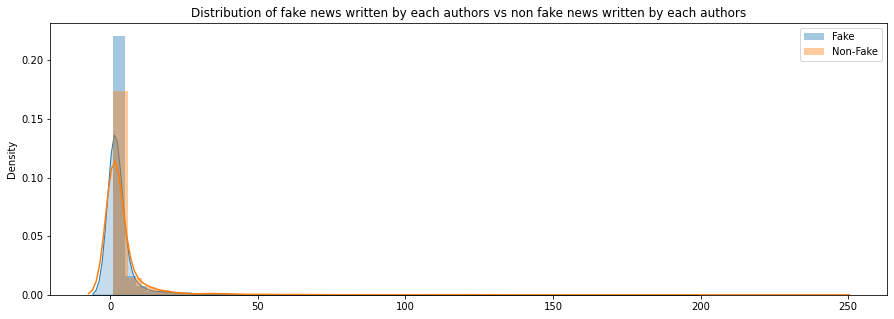

In [ ]:
### Distribution of news written by each authors
plt.figure(figsize=(15,5))
sns.distplot(data[data.label == 1].written_by.value_counts().values,label='Fake',kde_kws={'fill':True})
sns.distplot(data[data.label == 0].written_by.value_counts().values,label='Non-Fake')
plt.title('Distribution of fake news written by each authors vs non fake news written by each authors')
plt.legend()
plt.show()

In [ ]:
### Authors whose news were both fake and non fake
(data.groupby('written_by').label.nunique().sort_values()).tail(10)

written_by
Grace                                    1
Grady                                    1
Graham Bowley                            1
God and Country                          1
Giovanni Russonello and Daniel Victor    1
AFP                                      2
Ann Coulter                              2
Reuters                                  2
Pam Key                                  2
Pamela Geller                            2
Name: label, dtype: int64

In [ ]:
authors_both = ['AFP','Ann Coulter', 'Reuters', 'Pam Key', 'Pamela Geller']

In [ ]:
### Distribution of fake and non fake news written by the above set of authors
data[data.written_by.agg(lambda x: x in authors_both)].groupby('written_by').label.value_counts()

written_by     label
AFP            0          2
               1          1
Ann Coulter    0         16
               1          5
Pam Key        0        242
               1          1
Pamela Geller  1          4
               0          1
Reuters        0          4
               1          2
Name: label, dtype: int64

In [ ]:
### Top fake news writers
data[data.label==1].written_by.value_counts().head(20)

admin                                    192
Eddy Lavine                               85
Pakalert                                  85
Starkman                                  84
Gillian                                   82
Alex Ansary                               82
Editor                                    81
noreply@blogger.com (Alexander Light)     80
Dave Hodges                               77
IWB                                       75
BareNakedIslam                            74
The European Union Times                  74
Activist Post                             72
EdJenner                                  69
The Doc                                   69
Henry Wolff                               67
Iron Sheik                                66
Mac Slavo                                 66
Kaitlyn Stegall                           65
Jason Ditz                                64
Name: written_by, dtype: int64

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
### Create corpus of the news samples
text = []
_ = data.news.agg(lambda x: text.extend(str(x).strip().split()))

In [ ]:
len(text)

15711323

<Figure size 720x720 with 0 Axes>

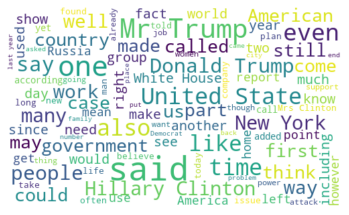

In [ ]:
### Word cloud of entire news
wordcloud = WordCloud(width=500, height=300, stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
### Create corpus of the fake news samples
fake_text = []
fake = data[data.label == 1].news.agg(lambda x: fake_text.extend(str(x).strip().split()))

In [ ]:
print('Total words in combined fake news : ',len(fake_text))
print('Words per sample in fake news : ',round(len(fake_text)/len(fake),2))

Total words in combined fake news :  6581186
Words per sample in fake news :  641.13


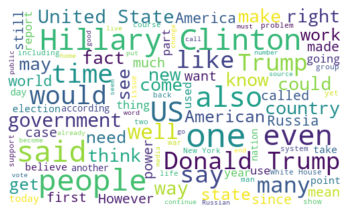

In [ ]:
### Word cloud of entire fake news
wordcloud = WordCloud(width=500, height=300, stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(' '.join(fake_text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
### Create corpus of the non fake news samples
non_text = []
non_fake = data[data.label == 0].news.agg(lambda x: non_text.extend(str(x).strip().split()))

In [ ]:
print('Total words in combined non fake news : ',len(non_text))
print('Words per sample in non fake news : ',round(len(non_text)/len(non_fake),2))

Total words in combined non fake news :  9130137
Words per sample in non fake news :  879.0


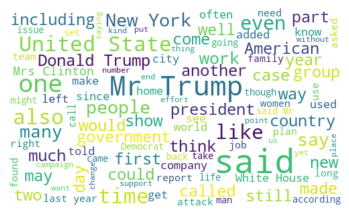

In [ ]:
### Word cloud of entire non fake news
wordcloud = WordCloud(width=500, height=300, stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(' '.join(non_text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
fake_words = []
f = set(fake_text) - (set(fake_text) & set (non_text))
for word in fake_text:
  if word in f:
    fake_words.append(word)

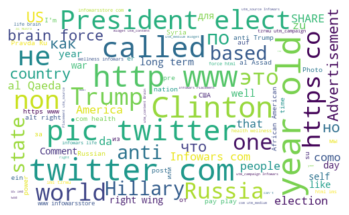

In [ ]:
### Words that differentiate news to be fake one
wordcloud = WordCloud(width=500, height=300, stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(' '.join(fake_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
non_words = []
f = set(non_text) - (set(fake_text) & set (non_text))
for word in non_text:
  if word in f:
    non_words.append(word)

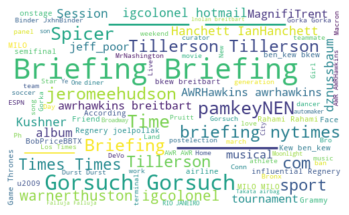

In [ ]:
### Words that differentiate news to be not fake
wordcloud = WordCloud(width=500, height=300, stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(' '.join(non_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Data cleaning and feature engineering**

In [ ]:
### Cleaning fuction: applies lowercase, replace numbers as 'numbr', replace non-character words and removes stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'£|\$', 'dollers', text)
    text = re.sub(r'\d+(\.\d+)?', 'numbr', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = [token for token in text.split() if token not in stop_words]
    return ' '.join(text)

In [ ]:
### Fill empty headlines as ' '
data.headline = data.headline.fillna(' ')

In [ ]:
### Apply cleaning on news column
data.loc[:,'news'] = data.news.apply(clean_text)

In [ ]:
### Apply cleaning on headline column
data.loc[:,'headline'] = data.headline.apply(clean_text)

In [ ]:
### Combine headline and news column
data['clean_text'] = (data.headline + ' ' + data.news)

In [ ]:
### Cleaned text
data.clean_text

0        ethics questions dogged agriculture nominee ge...
1        u must dig deep stop argentina lionel messi ne...
2        cotton house walk plank vote bill cannot pass ...
3        paul lepage besieged maine governor sends conf...
4        digital numbr numbr trump wins finian cunningh...
                               ...                        
20795                  dog licking vomit chinese overlords
20796    albert pike european migrant crisis rixon stew...
20797    dakota access caught infiltrating protests inc...
20798    stretch summer solstice new york times officia...
20799    emory university pay numbr percent undocumente...
Name: clean_text, Length: 20652, dtype: object

## **Training and evaluation**

In [ ]:
### Vectorizer
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)

In [ ]:
### Transform the clean text
tfs = tfidf.fit_transform(data.clean_text)

In [ ]:
### Feature dimesnions
print(tfs.shape)

(20652, 10000)


In [ ]:
### Select and train models, evalute the performances by cross validation

### LOGISTIC REGRESSION
lg = LogisticRegression()
scores_lg = cross_validate(lg, tfs, data.label, cv=5, scoring=['accuracy','f1_macro'], return_train_score=True)

### STOCHASTIC GRADIENT DESCENT
sgd = SGDClassifier()
scores_sgd = cross_validate(sgd, tfs, data.label, cv=5, scoring=['accuracy','f1_macro'], return_train_score=True)

### RANDOM FOREST CLASSIFIER
rf = RandomForestClassifier()
scores_rf = cross_validate(rf, tfs, data.label, cv=5, scoring=['accuracy','f1_macro'], return_train_score=True)

### LIGHT GRADIENT BOOSTING MACHINE
lgbm = LGBMClassifier()
scores_lgbm = cross_validate(lgbm, tfs, data.label, cv=5, scoring=['accuracy','f1_macro'], return_train_score=True)


### MULTINOMIAL NAIVE BAYES
mnb = MultinomialNB()
scores_mnb = cross_validate(mnb, tfs, data.label, cv=5, scoring=['accuracy','f1_macro'], return_train_score=True)

In [ ]:
### Get the accuracy and f1 scores of each model for trainig and testing 

models = ['LG','SGD','RF','LGBM','MNB']

test_accuracy = [scores_lg['test_accuracy'].mean(),
scores_sgd['test_accuracy'].mean(),
scores_rf['test_accuracy'].mean(),
scores_lgbm['test_accuracy'].mean(),
scores_mnb['test_accuracy'].mean()]

train_accuracy = [scores_lg['train_accuracy'].mean(),
scores_sgd['train_accuracy'].mean(),
scores_rf['train_accuracy'].mean(),
scores_lgbm['train_accuracy'].mean(),
scores_mnb['train_accuracy'].mean()]

test_f1 = [scores_lg['test_f1_macro'].mean(),
scores_sgd['test_f1_macro'].mean(),
scores_rf['test_f1_macro'].mean(),
scores_lgbm['test_f1_macro'].mean(),
scores_mnb['test_f1_macro'].mean()]

train_f1 = [scores_lg['train_f1_macro'].mean(),
scores_sgd['train_f1_macro'].mean(),
scores_rf['train_f1_macro'].mean(),
scores_lgbm['train_f1_macro'].mean(),
scores_mnb['train_f1_macro'].mean()]

# train_f1 = [scores_lg['train_f1_macro'].mean.(),
# scores_sgd['train_f1_macro'].mean(),
# scores_rf['train_f1_macro'].mean(),
# scores_lgbm['train_f1_macro'].mean(),
# scores_mnb['train_f1_macro'].mean()]

In [ ]:
### Score table
df = pd.DataFrame([test_accuracy,train_accuracy,test_f1,train_f1],
             index=['test_accuracy','train_accuracy','test_f1','train_f1'],
             columns=models)
df.T

test_accuracy  train_accuracy   test_f1  train_f1
LG         0.955743        0.974881  0.955742  0.974881
SGD        0.963393        0.985607  0.963393  0.985606
RF         0.961796        1.000000  0.961791  1.000000
LGBM       0.977145        0.999806  0.977145  0.999806
MNB        0.901172        0.916255  0.901002  0.916140

## **Hyper-parameter tuning SGD and LGBM classifiers**

#### **SGD**

In [ ]:
### Parameter dictionary for SGD
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge',  'perceptron']
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]
param_distributions = dict(loss=loss, 
                           penalty=penalty,
                           alpha=alpha, 
                           learning_rate=learning_rate, 
                           class_weight=class_weight,
                           eta0=eta0) 

In [ ]:
### Tune SGD classfiers and evaluate based on roc_auc scoring
random = RandomizedSearchCV(estimator=sgd,
                            param_distributions=param_distributions,
                            scoring='roc_auc',
                            verbose=1, n_jobs=-1,
                            cv=5,
                            n_iter=1000)

random_result = random.fit(tfs, data.label) 
print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 72.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 72.8min finished


Best Score:  0.9943112340712339
Best Params:  {'penalty': 'l2', 'loss': 'squared_hinge', 'learning_rate': 'adaptive', 'eta0': 100, 'class_weight': {1: 0.5, 0: 0.5}, 'alpha': 0.0001}


In [ ]:
### Get best estimator
best_sgd = random_result.best_estimator_

In [ ]:
### Save the SGD model
joblib.dump(best_sgd, 'fake_news_classification_best_sgd.pkl')

['fake_news_classification_best_sgd.pkl']

In [ ]:
### Take scores
scores_sgd = cross_validate(best_sgd, tfs, data.label, cv=5, scoring=['recall', 'precision', 'f1_macro'], return_train_score=True)

#### **LGBM**

In [ ]:
### Parameter dictionary for LGBM
num_leaves = sp_randint(6, 50)
min_child_samples = sp_randint(100, 500) 
min_child_weight = [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
reg_alpha = [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
reg_lambda = [0, 1e-1, 1, 5, 10, 20, 50, 100]
param_distributions = dict(loss=loss, 
                           min_child_samples=min_child_samples,
                           min_child_weight=min_child_weight, 
                           reg_alpha=reg_alpha, 
                           reg_lambda=reg_lambda) 

In [ ]:
### Tune LGBM classfiers and evaluate based on roc_auc scoring
random2 = RandomizedSearchCV(estimator=lgbm,
                            param_distributions=param_distributions,
                            scoring='roc_auc',
                            verbose=1, n_jobs=-1,
                            cv=5,
                            n_iter=100)

random_result2 = random2.fit(tfs, data.label) 
print('Best Score: ', random_result2.best_score_) 
print('Best Params: ', random_result2.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 83.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 92.3min finished


Best Score:  0.9972112116214451
Best Params:  {'loss': 'perceptron', 'min_child_samples': 115, 'min_child_weight': 1e-05, 'reg_alpha': 1, 'reg_lambda': 0}


In [ ]:
### Get best estimator
best_lgbm = random_result2.best_estimator_

In [ ]:
### Save the LGBM model
joblib.dump(best_lgbm, 'fake_news_classification_best_lgbm.pkl')

['fake_news_classification_best_lgbm.pkl']

In [ ]:
### Take scores
scores_lgbm = cross_validate(best_lgbm, tfs, data.label, cv=5, scoring=['recall', 'precision', 'f1_macro'], return_train_score=True)

## **Results and conclusion**

In [ ]:
### Get the precision, recall and f1 scores of each model for trainig and testing 

models = ['SGD','LGBM']

test_f1 = [scores_sgd['test_f1_macro'].mean(),
scores_lgbm['test_f1_macro'].mean()]

test_precision = [scores_sgd['test_precision'].mean(),
scores_lgbm['test_precision'].mean()]

test_recall = [scores_sgd['test_recall'].mean(),
scores_lgbm['test_recall'].mean()]

train_f1 = [scores_sgd['train_f1_macro'].mean(),
scores_lgbm['train_f1_macro'].mean()]

train_precision = [scores_sgd['train_precision'].mean(),
scores_lgbm['train_precision'].mean()]

train_recall = [scores_sgd['train_recall'].mean(),
scores_lgbm['train_recall'].mean()]

In [ ]:
### Score table
df = pd.DataFrame([test_recall,train_recall,test_precision,train_precision,test_f1,train_f1],
             index=['test_recall','train_recall','test_precision','train_precision','test_f1','train_f1'],
             columns=models)
df.T

test_recall  train_recall  ...   test_f1  train_f1
SGD      0.968631      0.991792  ...  0.964023  0.991635
LGBM     0.981101      0.997272  ...  0.975886  0.996586

[2 rows x 6 columns]

- SGD is slightly overfitted than LGBM
- LGBM has better recall and precision

Hence LGBM is best model for fake news detection

#### **Conclusion**

We have seen the words that could impact the probability of detecting a news as fake. There are many fake news writers, many of them are ‘admin’ and the chances were a writer, writing the real news are least likely to publish fake news.
We got Light gradient boosting machine as the best performing model in fake news detection with a precision of 97% and recall 98% in test set.
